In [1]:
from sklearn.model_selection import train_test_split
import random
import pickle
import csv
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader,TensorDataset
from torchvision import datasets, transforms
import torchvision.models as models
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
training_file = "./traffic-signs-data/train.p"
testing_file = "./traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

In [3]:
signs = []
with open('signnames.csv', 'r') as csvfile:
    signnames = csv.reader(csvfile, delimiter=',')
    next(signnames,None)
    for row in signnames:
        signs.append(row[1])
    csvfile.close()

In [4]:
# Extract features and labels
X, y = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

# Normalize images (Convert to range [0,1])
X = X / 255.0
X_test = X_test / 255.0

# Split training data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Preprocess Images

In [6]:
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),
    transforms.RandomAffine(0, shear=15, scale=(0.7, 1.3)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

from torch.utils.data import Dataset

class TrafficSignDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        # Ensure dtype is float32 and shape is (H, W, C)
        self.images = images.astype(np.float32)
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]  # shape: (32, 32, 3)
        label = self.labels[idx]
        
        # Convert from float32 to uint8 for ToPILImage compatibility
        image = (image * 255).astype(np.uint8)

        if self.transform:
            image = self.transform(image)
        return image, label
    
BATCH_SIZE = 32

train_data = TrafficSignDataset(X_train, y_train, transform=train_transform)
val_data = TrafficSignDataset(X_val, y_val, transform=test_transform)
test_data = TrafficSignDataset(X_test, y_test, transform=test_transform)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

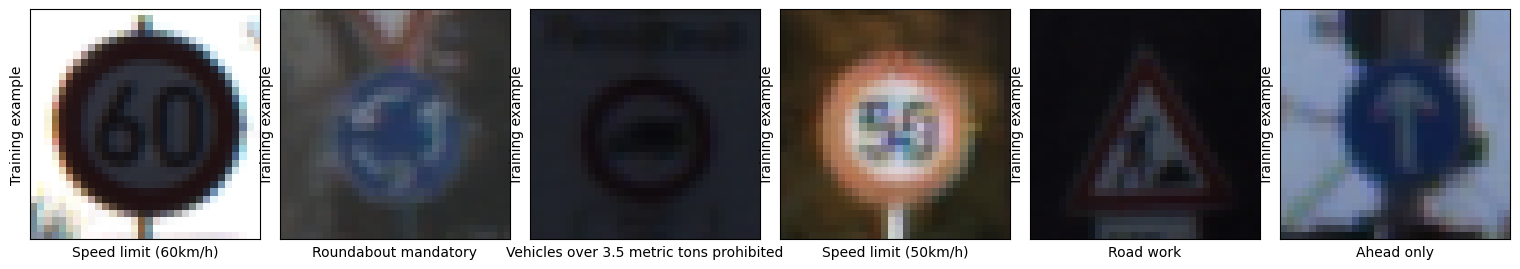

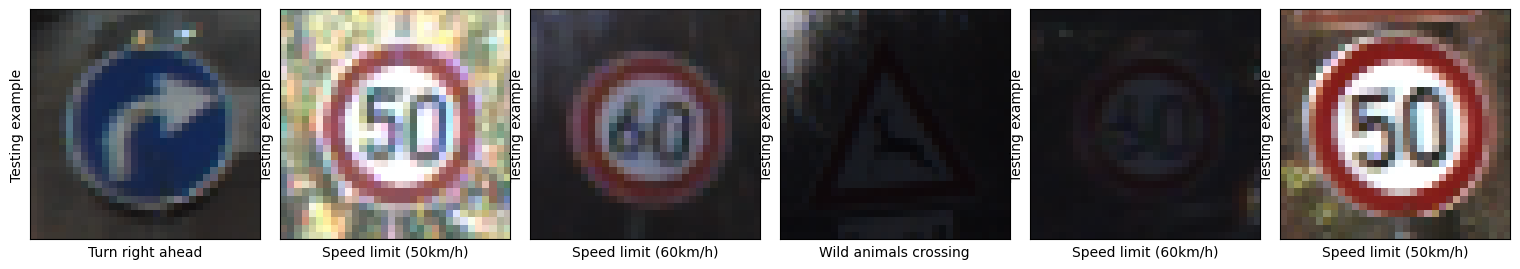

In [7]:
def list_images(dataset, dataset_y, ylabel="", cmap=None):
    plt.figure(figsize=(15, 16))
    for i in range(6):
        plt.subplot(1, 6, i+1)
        indx = random.randint(0, len(dataset))
        #Use gray scale color map if there is only one channel
        cmap = 'gray' if len(dataset[indx].shape) == 2 else cmap
        plt.imshow(dataset[indx], cmap = cmap)
        plt.xlabel(signs[dataset_y[indx]])
        plt.ylabel(ylabel)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()

list_images(X_train, y_train, "Training example")
list_images(X_test, y_test, "Testing example")

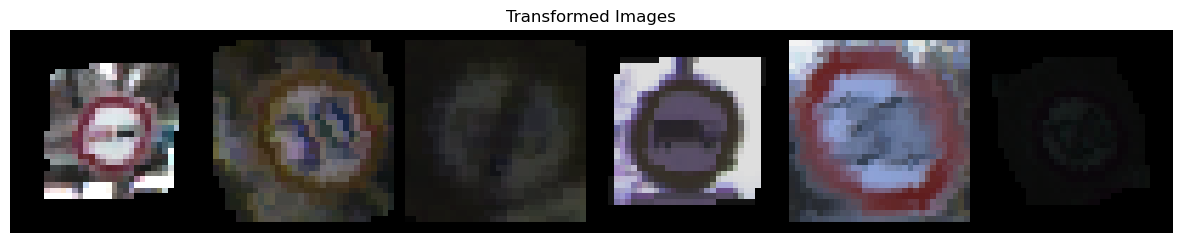

Label 1: No passing
Label 2: Speed limit (30km/h)
Label 3: End of speed limit (80km/h)
Label 4: Vehicles over 3.5 metric tons prohibited
Label 5: Speed limit (30km/h)
Label 6: Speed limit (120km/h)


In [8]:
def show_transformed_images(data_loader, signs, num_images=6):
    """Displays a batch of transformed images with their labels."""
    images, labels = next(iter(data_loader))
    images = images[:num_images]
    labels = labels[:num_images]

    # Denormalize the images for visualization
    images = images * 0.5 + 0.5  # assuming normalization with mean=0.5, std=0.5

    grid_img = torchvision.utils.make_grid(images, nrow=num_images)
    npimg = grid_img.permute(1, 2, 0).numpy()

    plt.figure(figsize=(15, 4))
    plt.imshow(npimg)
    plt.title('Transformed Images')
    plt.axis('off')
    plt.show()

    for i in range(num_images):
        print(f"Label {i+1}: {signs[labels[i].item()]}")

show_transformed_images(train_loader, signs)

In [9]:
def plot_loss_accuracy(trainLoss, valLoss, trainAcc, valAcc):
    """ Plot loss and accuracy curves."""
    fig, ax = plt.subplots(1,2,figsize=(16,5))
    ax[0].plot(trainLoss,'s-',label='Train Loss')
    ax[0].plot(valLoss,'o-',label='Validation Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Model Loss')
    ax[0].legend()
    
    ax[1].plot(trainAcc,'s-',label='Train Accuracy')
    ax[1].plot(valAcc,'o-',label='Validation Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy (%)')
    ax[1].set_title('Model Accuracy')
    ax[1].legend()
    plt.show()

In [10]:
def evaluate_model(model, test_loader, device):
    """ Evaluate the model on the test set and return accuracy."""
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            y_hat = model(X)
            predictions = torch.argmax(y_hat, dim=1)
            correct += (predictions == y).sum().item()
            total += y.size(0)
    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')
    return accuracy

In [11]:
def print_classification_report(model, data_loader, device, signs):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            y_hat = model(X)
            preds = torch.argmax(y_hat, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    print(classification_report(all_labels, all_preds, target_names=signs))

In [12]:
def plot_confusion_matrix(model, data_loader, device, signs, figsize=(12,10)):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            y_hat = model(X)
            preds = torch.argmax(y_hat, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=figsize)
    sns.heatmap(cm, xticklabels=signs, yticklabels=signs, annot=False, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

In [13]:
NUM_CLASSES = len(np.unique(y_train))
EPOCHS = 20

# LeNet-5 Model

In [15]:
def makeLeNet5(nclasses=43):
    class LeNet5(nn.Module):
        def __init__(self):
            super(LeNet5, self).__init__()
            self.conv_layers = nn.Sequential(
                nn.Conv2d(3, 100, kernel_size=5), nn.ReLU(), nn.MaxPool2d(2),
                nn.Conv2d(100, 150, kernel_size=3), nn.ReLU(), nn.MaxPool2d(2),
                nn.Conv2d(150, 250, kernel_size=3), nn.ReLU(), nn.MaxPool2d(2)
            )
            self.fc_layers = nn.Sequential(
                nn.Linear(250 * 2 * 2, 350), nn.ReLU(), nn.Dropout(0.7),
                nn.Linear(350, nclasses)
            )
        def forward(self, x):
            x = self.conv_layers(x)
            x = torch.flatten(x, 1)
            x = self.fc_layers(x)
            return F.log_softmax(x, dim=1)
    net = LeNet5()
    lossfun = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-4)
    return net, lossfun, optimizer

In [16]:
def trainModel(net, lossfun, optimizer, train_loader, val_loader, EPOCHS=20):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net = net.to(device)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)

    # Track losses and accuracy
    trainLoss = torch.zeros(EPOCHS)
    valLoss  = torch.zeros(EPOCHS)
    trainAcc  = torch.zeros(EPOCHS)
    valAcc    = torch.zeros(EPOCHS)

    best_val_acc = 0
    patience = 2
    epochs_no_improve = 0

    for epoch in range(EPOCHS):
        net.train()
        batch_loss = []
        batch_acc = []

        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = net(X)
            loss = lossfun(y_hat, y)
            loss.backward()
            optimizer.step()
            batch_loss.append(loss.item())
            predictions = torch.argmax(y_hat, dim=1)
            batch_acc.append((predictions == y).float().mean().item())

        trainLoss[epoch] = np.mean(batch_loss)
        trainAcc[epoch] = 100 * np.mean(batch_acc)

        # Validation Evaluation
        net.eval()
        val_loss, val_correct, total = 0.0, 0, 0
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                y_hat = net(X)
                val_loss += lossfun(y_hat, y).item()
                val_correct += (torch.argmax(y_hat, dim=1) == y).sum().item()
                total += y.size(0)

        valLoss[epoch] = val_loss / len(val_loader)
        valAcc[epoch] = 100 * (val_correct / total)

        print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {trainLoss[epoch]:.4f}, Val Loss: {valLoss[epoch]:.4f}, Train Acc: {trainAcc[epoch]:.2f}%, Val Acc: {valAcc[epoch]:.2f}%")

        scheduler.step()
        if valAcc[epoch] > best_val_acc:
            best_val_acc = valAcc[epoch]
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print("Early stopping triggered!")
            break

    return trainLoss, valLoss, trainAcc, valAcc, net, device

In [17]:
net, lossfun, optimizer = makeLeNet5()
trainLoss, valLoss, trainAcc, valAcc, trained_model, device = trainModel(net, lossfun, optimizer, train_loader, val_loader, EPOCHS=20)

Epoch 1/20 - Train Loss: 2.7528, Val Loss: 1.5873, Train Acc: 22.65%, Val Acc: 45.70%
Epoch 2/20 - Train Loss: 1.7100, Val Loss: 1.0945, Train Acc: 45.68%, Val Acc: 62.54%
Epoch 3/20 - Train Loss: 1.3549, Val Loss: 0.8164, Train Acc: 55.84%, Val Acc: 73.55%
Epoch 4/20 - Train Loss: 1.2055, Val Loss: 0.7283, Train Acc: 60.12%, Val Acc: 75.85%
Epoch 5/20 - Train Loss: 1.1306, Val Loss: 0.6818, Train Acc: 62.61%, Val Acc: 77.80%
Epoch 6/20 - Train Loss: 1.0965, Val Loss: 0.6569, Train Acc: 63.26%, Val Acc: 79.17%
Epoch 7/20 - Train Loss: 1.0780, Val Loss: 0.6416, Train Acc: 64.27%, Val Acc: 80.45%
Epoch 8/20 - Train Loss: 1.0624, Val Loss: 0.6314, Train Acc: 64.74%, Val Acc: 80.27%
Epoch 9/20 - Train Loss: 1.0620, Val Loss: 0.6315, Train Acc: 64.47%, Val Acc: 80.55%
Epoch 10/20 - Train Loss: 1.0592, Val Loss: 0.6291, Train Acc: 64.98%, Val Acc: 80.56%
Epoch 11/20 - Train Loss: 1.0743, Val Loss: 0.6276, Train Acc: 64.70%, Val Acc: 80.75%
Epoch 12/20 - Train Loss: 1.0494, Val Loss: 0.6278, 

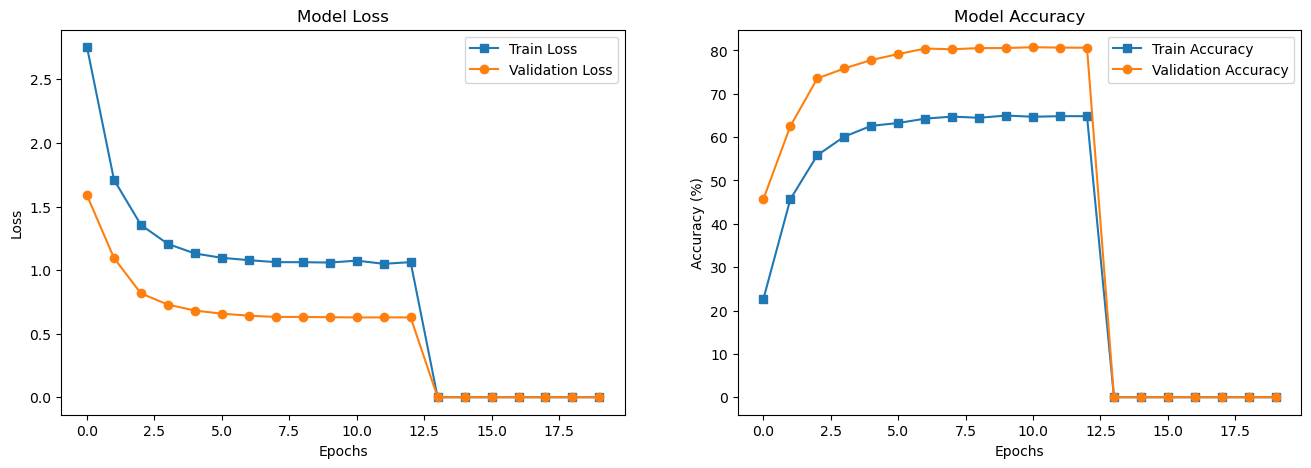

Test Accuracy: 75.93%


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                                                    precision    recall  f1-score   support

                              Speed limit (20km/h)       0.00      0.00      0.00        60
                              Speed limit (30km/h)       0.75      0.72      0.74       720
                              Speed limit (50km/h)       0.65      0.54      0.59       750
                              Speed limit (60km/h)       0.87      0.67      0.76       450
                              Speed limit (70km/h)       0.84      0.88      0.86       660
                              Speed limit (80km/h)       0.44      0.45      0.45       630
                       End of speed limit (80km/h)       0.77      0.77      0.77       150
                             Speed limit (100km/h)       0.53      0.59      0.56       450
                             Speed limit (120km/h)       0.57      0.84      0.68       450
                                        No passing       0.95      0.98      0.

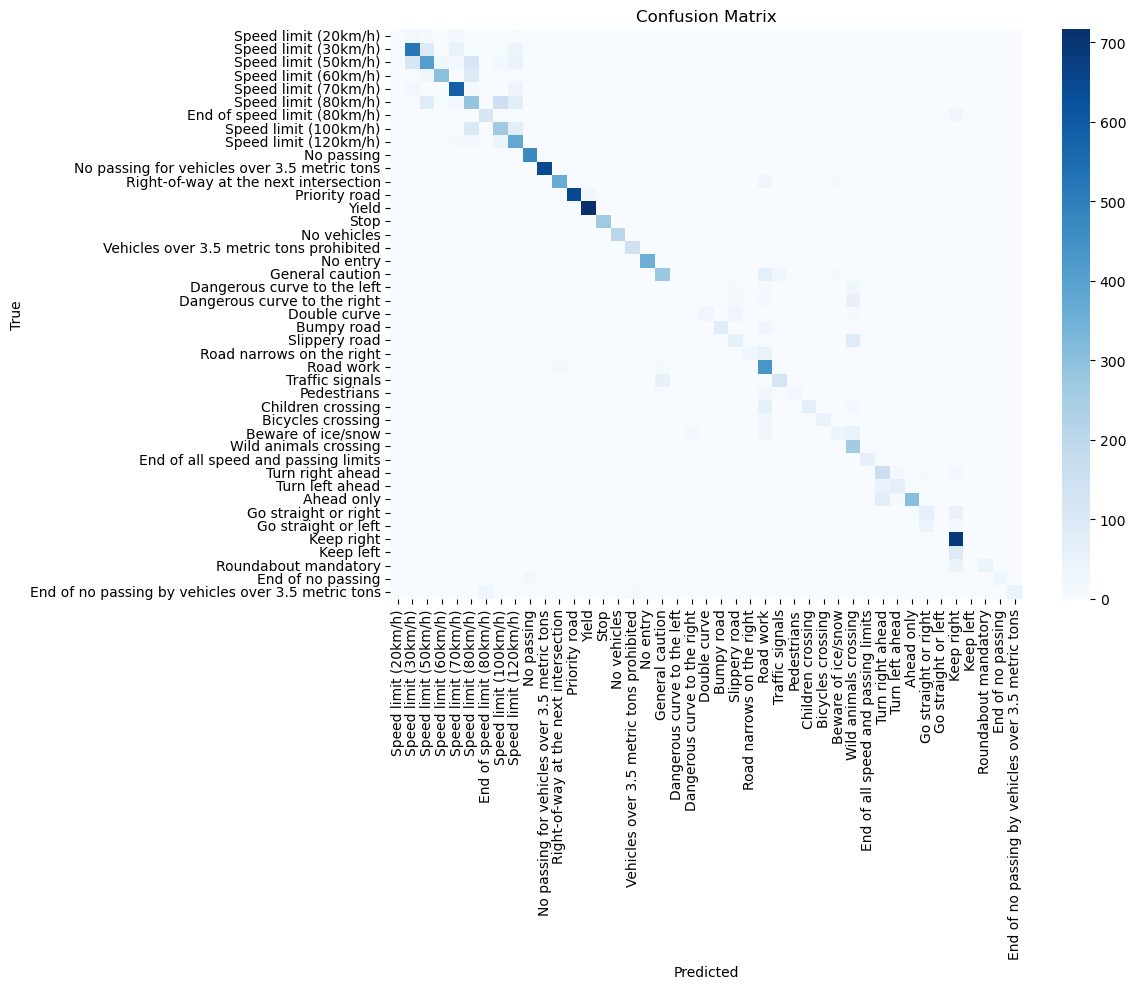

In [18]:
plot_loss_accuracy(trainLoss, valLoss, trainAcc, valAcc)
evaluate_model(trained_model, test_loader, device)
print_classification_report(trained_model, test_loader, device, signs)
plot_confusion_matrix(trained_model, test_loader, device, signs)

# VGGNet Model

In [28]:
def makeVGGNet():
    class VGGNet(nn.Module):
        def __init__(self, nclasses=43):
            super(VGGNet, self).__init__()
            self.conv_layers = nn.Sequential(
                nn.Conv2d(3, 64, kernel_size=3, padding=1), nn.ReLU(),
                nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.ReLU(),
                nn.MaxPool2d(2, 2),

                nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(),
                nn.Conv2d(128, 128, kernel_size=3, padding=1), nn.ReLU(),
                nn.MaxPool2d(2, 2),

                nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.ReLU(),
                nn.Conv2d(256, 256, kernel_size=3, padding=1), nn.ReLU(),
                nn.MaxPool2d(2, 2),
            )
            self.fc_layers = nn.Sequential(
                nn.Linear(256 * 4 * 4, 512), nn.ReLU(), nn.Dropout(0.5),
                nn.Linear(512, 512), nn.ReLU(), nn.Dropout(0.5),
                nn.Linear(512, nclasses)
            )

        def forward(self, x):
            x = self.conv_layers(x)
            x = torch.flatten(x, 1)
            x = self.fc_layers(x)
            return F.log_softmax(x, dim=1)

    net = VGGNet()
    lossfun = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.0001, weight_decay=1e-4)
    return net, lossfun, optimizer

In [29]:
net, lossfun, optimizer = makeVGGNet()
trainLoss, valLoss, trainAcc, valAcc, trained_model, device = trainModel(net, lossfun, optimizer, train_loader, val_loader, EPOCHS=20)

Epoch 1/20 - Train Loss: 3.4500, Val Loss: 3.1181, Train Acc: 6.74%, Val Acc: 14.01%
Epoch 2/20 - Train Loss: 3.0837, Val Loss: 2.5629, Train Acc: 13.50%, Val Acc: 25.33%
Epoch 3/20 - Train Loss: 2.6358, Val Loss: 2.1674, Train Acc: 23.37%, Val Acc: 33.69%
Epoch 4/20 - Train Loss: 2.4293, Val Loss: 2.0288, Train Acc: 27.44%, Val Acc: 35.57%
Epoch 5/20 - Train Loss: 2.3438, Val Loss: 1.9855, Train Acc: 28.98%, Val Acc: 36.22%
Epoch 6/20 - Train Loss: 2.3112, Val Loss: 1.9652, Train Acc: 29.66%, Val Acc: 36.34%
Epoch 7/20 - Train Loss: 2.2927, Val Loss: 1.9524, Train Acc: 29.63%, Val Acc: 36.58%
Epoch 8/20 - Train Loss: 2.2795, Val Loss: 1.9476, Train Acc: 30.26%, Val Acc: 36.72%
Epoch 9/20 - Train Loss: 2.2738, Val Loss: 1.9451, Train Acc: 29.82%, Val Acc: 36.68%
Epoch 10/20 - Train Loss: 2.2766, Val Loss: 1.9418, Train Acc: 29.83%, Val Acc: 36.78%
Epoch 11/20 - Train Loss: 2.2807, Val Loss: 1.9421, Train Acc: 29.75%, Val Acc: 36.71%
Epoch 12/20 - Train Loss: 2.2724, Val Loss: 1.9421, T

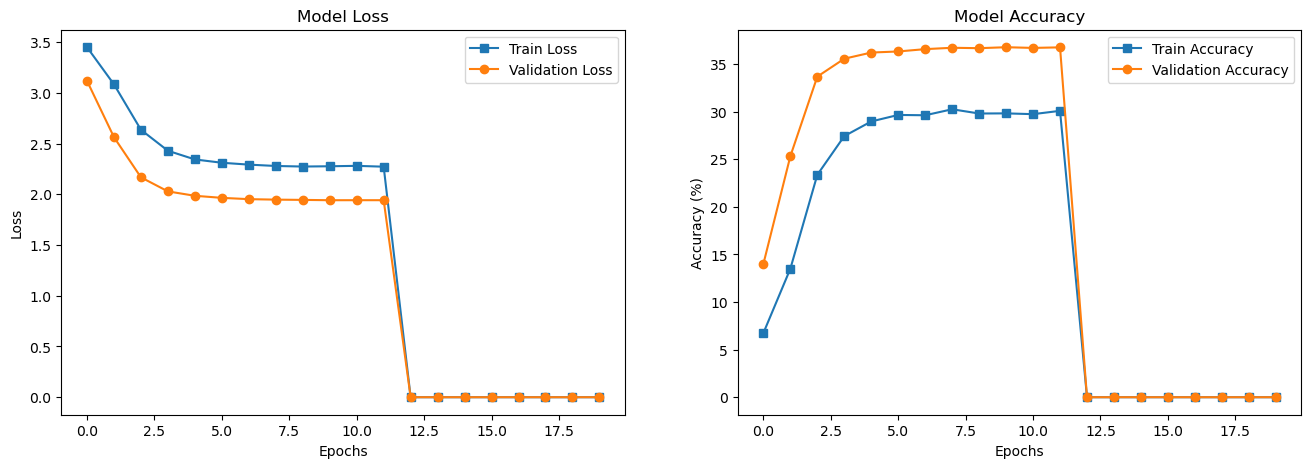

Test Accuracy: 36.02%


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                                                    precision    recall  f1-score   support

                              Speed limit (20km/h)       0.00      0.00      0.00        60
                              Speed limit (30km/h)       0.31      0.49      0.38       720
                              Speed limit (50km/h)       0.28      0.46      0.34       750
                              Speed limit (60km/h)       0.00      0.00      0.00       450
                              Speed limit (70km/h)       0.16      0.25      0.19       660
                              Speed limit (80km/h)       0.07      0.08      0.07       630
                       End of speed limit (80km/h)       0.00      0.00      0.00       150
                             Speed limit (100km/h)       0.20      0.01      0.02       450
                             Speed limit (120km/h)       0.22      0.11      0.14       450
                                        No passing       0.66      0.58      0.

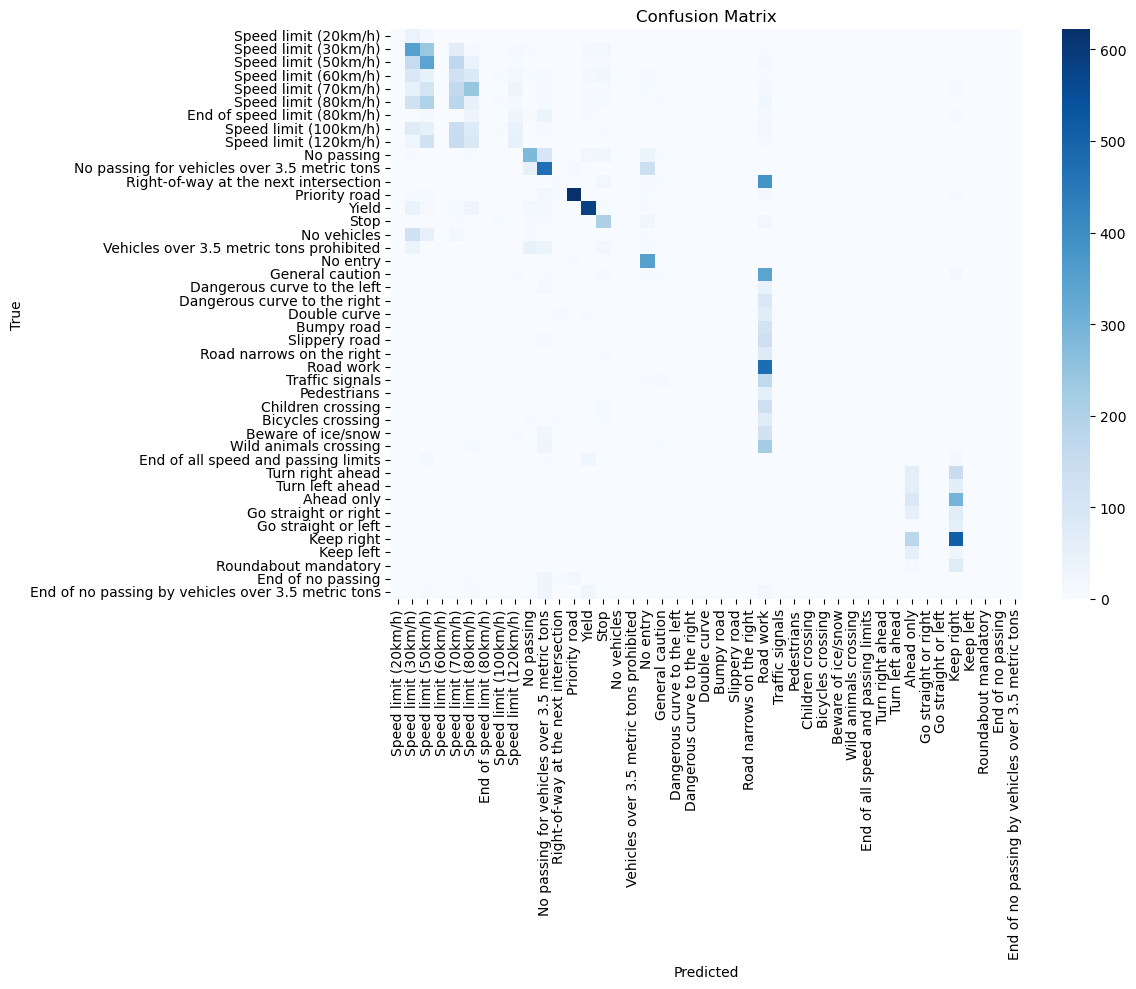

In [30]:
plot_loss_accuracy(trainLoss, valLoss, trainAcc, valAcc)
evaluate_model(trained_model, test_loader, device)
print_classification_report(trained_model, test_loader, device, signs)
plot_confusion_matrix(trained_model, test_loader, device, signs)